## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

# Разберемся c показателями

age: continuous.

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

fnlwgt: continuous (ТАК И НЕ ПОНYAТНО, ЧТО ЭТО ЗА ПЕРЕМЕННАYA).

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

sex: Female, Male.

capital-gain: continuous.

capital-loss: continuous.

hours-per-week: continuous.

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherland

In [108]:
import numpy as np
import pandas as pd

In [188]:
# Вижу, что в выборке 16,280 наблюдений
# К сожалению, '?' не считается за миссинг, поэтому просто смотрим сколько наблюдений в dataset'е
data = pd.read_csv('data.adult.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [189]:
# Вариант 1 - как в задании: найти все признаки, имеющие пропущенные значения и удалитьвсе объекты с пропусками
# Лиза, наапишите, пожалуйста, ваш вариант с index, спасибо 

# Нахожу значения с "?" и перекодирую в np.nan  
data[data=='?']=np.nan

# Найду количество миссингов 
data.isnull().sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [190]:
# Вариант 1 (продолжение) - как в задании: найти все признаки, имеющие пропущенные значения и удалитьвсе объекты с пропусками
# Лиза, напишите, пожалуйста, ваш вариант с index, спасибо 

# Удалю строки, в которых хотя бы 1 раз встретился NaN
data.dropna(axis=0,inplace=True)

# Проверю, что в выборке теперь нет NaN -> число наблюдений уменьшилось, все ОК
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


In [112]:
# Вариант 2 - когда буду подгружать файл, сразу обозначу, какие значения во всем файле будут считаться миссингами
# Объявлю новую переменную куда закину все значения, которые буду считать миссингами.
# На всякий случай, добавлю в миссинг еще пару-тройку значений, которые можно также квалифицировать в качестве NaN: 'NA','n/a', 'na'
missing_values = ['NA','n/a', 'na', '?']

# Создам новую переменную data1, которая "откроет" файл с данными и укажу, что считать NaN'ом
data10 = pd.read_csv('data.adult.csv', na_values = missing_values)

# Удалю строки, в которых хотя бы 1 раз встретился NaN 
data10.dropna(axis=0,inplace=True)

# Проверю, что в выборке теперь нет NaN -> число наблюдений уменьшилось, все ОК
data10.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


In [113]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [115]:
# Выделю целевую переменную 
y = data['>50K,<=50K']

# Преобразую таргет к бинарному формату
y = y.map({'<=50K':0, '>50K':1})
y.head()

0    0
1    0
2    0
3    0
4    1
Name: >50K,<=50K, dtype: int64

In [116]:
# Выделю вещественные признаки (=int64)
X_int=data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
X_int.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [76]:
# Разбиваю X_int и y на train и test - не буду разбивать

# from sklearn.model_selection import train_test_split
# Xtrain, Xtest, ytrain, ytest = train_test_split(X_int, y, test_size=0.3, random_state=1) 
# Xtrain.shape

(10742, 6)

In [120]:
%%time
# Импортирую модели ближайших соседей, SGD Linear Classifier, GridSearch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Объявлю модели
model_knn = KNeighborsClassifier()
model_sgd = SGDClassifier(max_iter=100000)

# Задам поле для поиска гиперпараметров
params_knn = {'n_neighbors': np.arange(1,50,1)}
params_sgd = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','huber','epsilon_insensitive','squared_epsilon_insensitive')} 

# Объявлю GridSearchCV, 5 фолдов
gs_knn = GridSearchCV(model_knn, params_knn, cv=5, scoring ='roc_auc')
gs_sgd = GridSearchCV(model_sgd, params_sgd, cv=5, scoring ='roc_auc')

# Обучу модели
gs_knn.fit(X_int, y)
gs_sgd.fit(X_int, y)


Wall time: 56.5 s


GridSearchCV(cv=5, estimator=SGDClassifier(max_iter=100000),
             param_grid={'loss': ('hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive')},
             scoring='roc_auc')

In [121]:
%%time
# Посмотрю на лучшее значение метрики качества моделей

BS_knn = gs_knn.best_score_
BS_sgd = gs_sgd.best_score_

print('Best Score KNN: ', BS_knn)
print('Best Score SGD: ', BS_sgd)

Best Score KNN:  0.6407170629127037
Best Score SGD:  0.6170389153456993
Wall time: 0 ns


In [122]:
%%time
# Посмотрю на лучший эстиматор моделей
ES_knn = gs_knn.best_params_
ES_sgd = gs_sgd.best_estimator_

print('Лучший эстиматор KNN: ', ES_knn)
print('Лучший эстиматор SGD: ', ES_sgd)

Лучший эстиматор KNN:  {'n_neighbors': 4}
Лучший эстиматор SGD:  SGDClassifier(loss='perceptron', max_iter=100000)
Wall time: 1.99 ms


In [123]:
# Выведу все значения качества, которые получились перебором через GridSearch, а также другие показатели  
gs_knn.cv_results_

Wall time: 0 ns


{'mean_fit_time': array([0.05414882, 0.04723086, 0.05356293, 0.05527868, 0.04599094,
        0.0458859 , 0.04551959, 0.04736228, 0.04720397, 0.04207315,
        0.04659452, 0.04565701, 0.04854312, 0.0489449 , 0.04920015,
        0.05175028, 0.04831643, 0.05034022, 0.04561148, 0.04811316,
        0.04652834, 0.04897547, 0.0547184 , 0.04456272, 0.05074182,
        0.05015593, 0.04949341, 0.05215616, 0.04712586, 0.04760451,
        0.04763031, 0.04772997, 0.04833593, 0.0579998 , 0.05257754,
        0.0502634 , 0.04644494, 0.04757051, 0.05081477, 0.05166545,
        0.05079761, 0.05085955, 0.04478431, 0.04615173, 0.04585438,
        0.04775763, 0.04702568, 0.04408684, 0.04694986]),
 'std_fit_time': array([0.00562132, 0.00164054, 0.00492775, 0.00606098, 0.00367358,
        0.00211856, 0.0013659 , 0.00263487, 0.00214779, 0.00262458,
        0.00057982, 0.00347723, 0.00274293, 0.00353626, 0.00124905,
        0.00114984, 0.00134099, 0.00276329, 0.00286851, 0.00545695,
        0.00307337, 0.003

Wall time: 101 ms


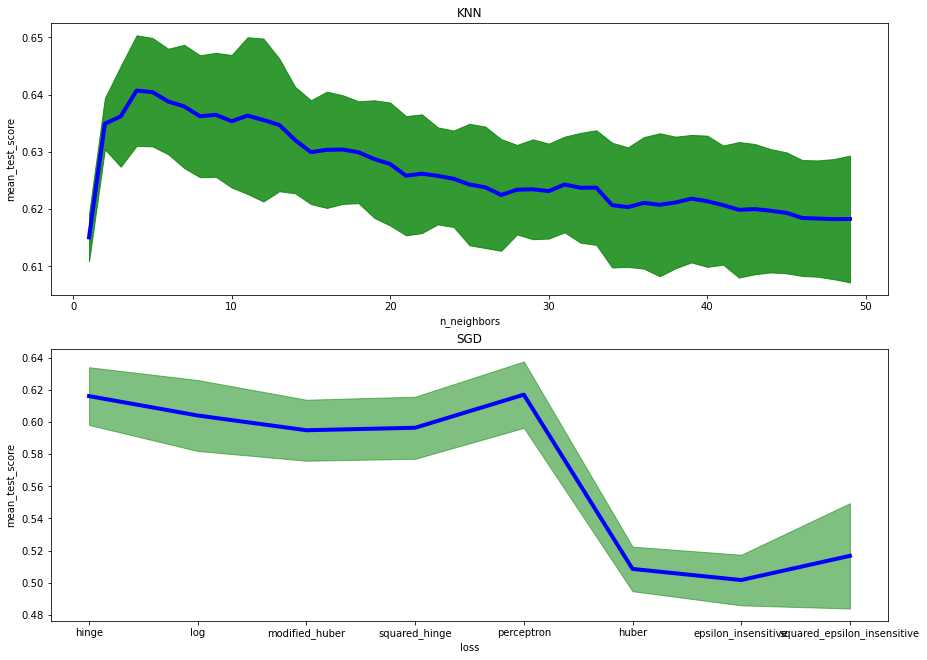

In [124]:
%%time

# Нарисую график зависимости между качеством и числом соседей (гиперпараметр KNN), с учетом стандартной ошибки
# Очень сложно, особенно если учесть, что мы этого не проходили...

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(15,11))

x_knn = [int(*i.values()) for i in gs_knn.cv_results_['params']] 
y_knn = gs_knn.cv_results_['mean_test_score']
ci_knn = gs_knn.cv_results_['std_test_score']

ax[0].plot(x_knn, y_knn, color='blue', linewidth=4)
ax[0].set_xlabel('n_neighbors')
ax[0].set_ylabel('mean_test_score')
ax[0].set_title('KNN')
ax[0].fill_between(x_knn, y_knn-ci_knn, y_knn+ci_knn, color='green', alpha=0.8)

# Нарисую график зависимости между качеством и типом оптимизирующей функции loss, с учетом стандартной ошибки

x_sgd = [str(*i.values()) for i in gs_sgd.cv_results_['params']] 
y_sgd = gs_sgd.cv_results_['mean_test_score']
ci_sgd = gs_sgd.cv_results_['std_test_score']

ax[1].plot(x_sgd, y_sgd, color='blue', linewidth=4)
ax[1].set_xlabel('loss')
ax[1].set_ylabel('mean_test_score')
ax[1].set_title('SGD')
ax[1].fill_between(x_sgd, y_sgd-ci_sgd, y_sgd+ci_sgd, color='green', alpha=0.5)

# Что вы можете сказать о получившихся графиках?


## Наблюдение 1:
Результаты оптимизации KNN приводят к более "плотным" показателям качества модели (0,61->0,65). То есть, гиперпараметр "число соседей" оказывает заметно мЕньшее влияние на итоговый результат, чем параметр "loss" в стохастическом градиентом спуске (0,51->0,62) 


## Наблюдение 2:
Качество KNN максимизируется в районе 5 соседей, дальнейшее увеличение приводит к постепенной деградации, поэтому увеличивать их количество нет смысла.     
В SGD четыре функции потерь приводят к одинаковому результату, который очень близок к KNN. Три функции - 'huber', 'epsilon_incentive' и '' заметно проигрывают. 

## Наблюдение 3:
По уровню разброса качества модели очень похожи, однако KNN чуть впереди  


Что вы можете сказать о получившихся графиках?

**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.

In [82]:
# Посмотрю на то, что можно менять в модели SVC
from sklearn.svm import LinearSVC
LinearSVC().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [125]:
%%time

# Предварительный анализ (я его опущу для экономии места) показал, что:
# для линейной регрессии С лежит в районе 0.001, поэтому сужу поиск до окрестностей этой точки 
# для LinearSVC C лежит в районе 70, поэтому сужу поиск до окрестностей этой точки

#Импортирую модели логистической регрессии и SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Объявлю модели
model_lr = LogisticRegression()
model_lsvc = LinearSVC(max_iter=1000)

# Задам поле для поиска гиперпараметров
params_lr = {'C' : np.arange(0.0001,0.01, 0.001)}
params_lsvc = {'C': np.arange(20,99,1)} 

# Объявлю GridSearchCV, 5 фолдов
gs_lr = GridSearchCV(model_lr, params_lr, cv=5, scoring ='roc_auc')
gs_lsvc = GridSearchCV(model_lsvc, params_lsvc, cv=5, scoring ='roc_auc')

# Обучу модели
gs_lr.fit(X_int, y)
gs_lsvc.fit(X_int, y)

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Wall time: 4min 39s


C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])},
             scoring='roc_auc')

In [126]:
# Посмотрю на лучшее значение метрики качества моделей
BS_lr = gs_lr.best_score_
BS_lsvc = gs_lsvc.best_score_

print('Best Score LR: ', BS_lr)
print('Best Score LinearSVC: ', BS_lsvc)

Best Score LR:  0.57452513900976
Best Score LinearSVC:  0.5800614397284166


In [127]:
# Посмотрю на лучший эстиматор моделей
ES_lr = gs_lr.best_estimator_
ES_lsvc = gs_lsvc.best_estimator_

print('Лучший эстиматор LR: ', ES_lr)
print('Лучший эстиматор LinearSVC: ', ES_lsvc)

Лучший эстиматор LR:  LogisticRegression(C=0.0001)
Лучший эстиматор LinearSVC:  LinearSVC(C=45)


**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

In [128]:
%%time

# Предположу, что признаки распределены нормально, поэтому буду использовать тот вариант НБА,
# который предполагает модель Гаусса
# Использую единственный гипер-параметр 'var_smoothing'

# Импортирую НБА и, в частности, Гаусса
from sklearn.naive_bayes import GaussianNB

# Объявлю модель
model_nb = GaussianNB()

# Задам поле для поиска гиперпараметров -> узнал тут про новую функцию, решил использовать
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)} 

# Объявлю GridSearchCV, 5 фолдов
gs_nb = GridSearchCV(model_nb, params_nb, cv=5)

# Обучу модель 
gs_nb.fit(X_int, y)

Wall time: 3.8 s


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [129]:
# Посмотрю на лучший эстиматор 
ES_nb = gs_nb.best_estimator_
print('Лучший эстиматор НБА (Гаусс): ', ES_nb)

# Посмотрю на лучшее значение метрики качества 
BS_nb = gs_nb.best_score_
print('Best Score НБА (Гаусс): ', BS_nb)

Лучший эстиматор НБА (Гаусс):  GaussianNB(var_smoothing=1.2328467394420658e-05)
Best Score НБА (Гаусс):  0.7927933745355202


При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Wall time: 145 ms


Text(0.5, 1.0, 'capital-gain')

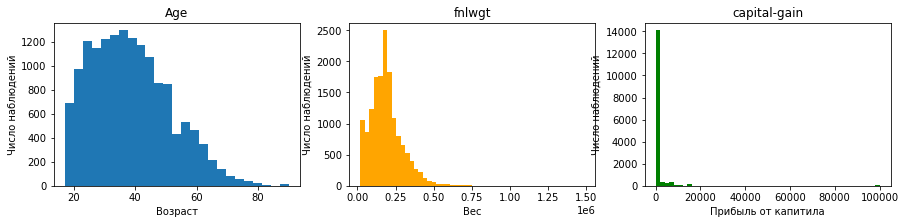

In [130]:
%%time

# Импортирую модель для отрисовки гистограмм - matplotlib  
import matplotlib.pyplot as plt

# Задам размер для отрисовки гистограмм
fig, ax = plt.subplots(1,3, figsize=(15,3))

# Рисую гистограмму по возрасту
ax[0].hist(X_int['age'], bins=25)
ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Число наблюдений')
ax[0].set_title('Аge')


# Рисую гистограмму по весу 'fnlwgt'
ax[1].hist(X_int['fnlwgt'], bins=50, color='orange')
ax[1].set_xlabel('Вес')
ax[1].set_ylabel('Число наблюдений')
ax[1].set_title('fnlwgt')


# Рисую гистограмму по размеру прибыли от капитила 'capital-gain'
ax[2].hist(X_int['capital-gain'], bins=50, color='green')
ax[2].set_xlabel('Прибыль от капитила')
ax[2].set_ylabel('Число наблюдений')
ax[2].set_title('capital-gain')

## Постройте гистограммы для признаков age, fnlwgt, capital-gain. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Вижу, что Age меняется в масштабе от 15 до  100 лет, fnlwt - от 0 до 1,5, а capital-gain - 0 до 100,000. Очевидно, что масштаб переменных НЕ одинаковый -> это должно  оказывать влияние на все алгоритмы, кроме Наивного Байеса (ПРОВЕРИМ В АНАЛИЗЕ ДАЛЬШЕ!). 

### Запущу масштабирование признаков

Какие моедели используем:
kNN
SGD Linear Classifier
Naive Bayes Classifier
Logistic Regression
SVC (Support Vector Classifier)

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [212]:
%%time

# Установлю скалер для нормировки
from sklearn.preprocessing import StandardScaler

# Обучусь на X_int (по y учиться НЕ надо, так как там изначально 0 и 1), найду среднее и станд отклонение 
scaler = StandardScaler().fit(X_int)

# Отнормирую X_int по данным Xtrain 
X_int_sc = scaler.transform(X_int) 

Wall time: 9.49 ms


In [213]:
# Посмотрю, как выглядят отнормированные переменные -> как array  в numpy
X_int_sc

array([[-0.3429185 ,  0.90025802, -0.45078777, -0.06559951, -0.21874041,
         1.58822305],
       [ 0.11476013,  0.01068271, -0.05908582, -0.15043862, -0.21874041,
        -0.07417817],
       [-0.19035896, -0.10628026,  1.11602004, -0.15043862, -0.21874041,
        -0.07417817],
       ...,
       [-0.8768769 , -0.79685293,  1.11602004, -0.15043862, -0.21874041,
        -0.07417817],
       [ 1.56407578,  0.74838115, -0.45078777, -0.15043862, -0.21874041,
        -0.07417817],
       [-0.41919828, -1.22374144,  1.11602004, -0.15043862,  4.47344431,
         0.34142214]])

In [139]:
# Поскольку отнормированные переменные находятся в формате NumPy, их надо привести в формат dataframes
X_int_sc = pd.DataFrame(X_int_sc, columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']) 
X_int_sc.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.21874,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.21874,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.21874,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.21874,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.21874,-0.074178


In [135]:
%%time

# Запущу все модели заново на отнормированных тестовых данных

# Импортирую модели ближайших соседей, SGD Linear Classifier, Логистической регресии,
# LinearSVC и GridSearch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Объявлю модели
model_knn = KNeighborsClassifier()
model_sgd = SGDClassifier(max_iter=100000)
model_lr = LogisticRegression()
model_lsvc = LinearSVC(max_iter=1000)
model_nb = GaussianNB()

# Задам поле для поиска гиперпараметров - немного расширю поле поиска, так как поcле нормализации оптимальное значение
# может измениться и лежать в другой окресности
params_knn_sc = {'n_neighbors': np.arange(1,100,1)}
params_sgd_sc = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','huber','epsilon_insensitive','squared_epsilon_insensitive')} 
params_lr_sc = {'C': np.arange(0.01,1, 0.01)}
params_lsvc_sc = {'C': np.arange(1,99,1)} 
params_nb_sc = {'var_smoothing': np.logspace(0,-9, num=100)} 

# Объявлю GridSearchCV, 5 фолдов
gs_knn_sc = GridSearchCV(model_knn, params_knn_sc, cv=5, scoring ='roc_auc')
gs_sgd_sc = GridSearchCV(model_sgd, params_sgd_sc, cv=5, scoring ='roc_auc')
gs_lr_sc = GridSearchCV(model_lr, params_lr_sc, cv=5, scoring ='roc_auc')
gs_lsvc_sc = GridSearchCV(model_lsvc, params_lsvc_sc, cv=5, scoring ='roc_auc')
gs_nb_sc = GridSearchCV(model_nb, params_nb_sc, cv=5, scoring ='roc_auc')

# Обучу модели на нормированных данных
gs_knn_sc.fit(X_int_sc, y)
gs_sgd_sc.fit(X_int_sc, y)
gs_lr_sc.fit(X_int_sc, y)
gs_lsvc_sc.fit(X_int_sc, y)
gs_nb_sc.fit(X_int_sc, y)

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Wall time: 9min 43s


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc')

In [138]:
%%time

# Посмотрю на лучшее значение метрики качества моделей на НОРМИРОВАННЫХ данных
BS_knn_sc = gs_knn_sc.best_score_
BS_sgd_sc = gs_sgd_sc.best_score_
BS_lr_sc = gs_lr_sc.best_score_
BS_lsvc_sc = gs_lsvc_sc.best_score_
BS_lsvc_sc = gs_lsvc_sc.best_score_
BS_nb_sc = gs_nb_sc.best_score_


print('Best Score KNN: ', BS_knn)
print('Best Score KNN (SCALED): ', BS_knn_sc)
print()

print('Best Score SGD: ', BS_sgd)
print('Best Score SGD (SCALED): ', BS_sgd_sc)
print()

print('Best Score LR: ', BS_lr)
print('Best Score LR (SCALED): ', BS_lr_sc)
print()

print('Best Score LinearSVC: ', BS_lsvc)
print('Best Score LinearSVC (SCALED): ', BS_lsvc_sc)
print()

print('Best Score НБА (Гаусс): ', BS_nb)
print('Best Score НБА, Гаусс (SCALED): ', BS_nb_sc)

Best Score KNN:  0.6407170629127037
Best Score KNN (SCALED):  0.8342380287757438

Best Score SGD:  0.6170389153456993
Best Score SGD (SCALED):  0.8216722353777856

Best Score LR:  0.57452513900976
Best Score LR (SCALED):  0.8251617903634305

Best Score LinearSVC:  0.5800614397284166
Best Score LinearSVC (SCALED):  0.8246721702618578

Best Score НБА (Гаусс):  0.7927933745355202
Best Score НБА, Гаусс (SCALED):  0.8308654407329719
Wall time: 0 ns


In [137]:
%%time

# Посмотрю на лучший эстиматор моделей на НОРМИРОВАННЫХ данных
ES_knn_sc = gs_knn_sc.best_params_
ES_sgd_sc = gs_sgd_sc.best_estimator_
ES_lr_sc = gs_lr_sc.best_estimator_
ES_lsvc_sc = gs_lsvc_sc.best_estimator_
ES_nb_sc = gs_nb_sc.best_estimator_

print('Лучший эстиматор KNN (SCALED): ', ES_knn_sc)
print('Лучший эстиматор SGD (SCALED): ', ES_sgd_sc)
print('Лучший эстиматор LR (SCALED): ', ES_lr_sc)
print('Лучший эстиматор LinearSVC (SCALED): ', ES_lsvc_sc)
print('Лучший эстиматор НБА, Гаусс (SCALED): ', ES_nb_sc)

Лучший эстиматор KNN (SCALED):  {'n_neighbors': 39}
Лучший эстиматор SGD (SCALED):  SGDClassifier(loss='log', max_iter=100000)
Лучший эстиматор LR (SCALED):  LogisticRegression(C=0.060000000000000005)
Лучший эстиматор LinearSVC (SCALED):  LinearSVC(C=13)
Лучший эстиматор НБА, Гаусс (SCALED):  GaussianNB(var_smoothing=0.12328467394420659)
Wall time: 2 ms


## Изменилось ли качество у некоторых алгоритмов?
Да, качество заметно выросло у всех моделей: с 58%-63% до 82%-83%. Наименьшое улучшение у Наивного Байеса: 0,79->0,83. Предположение из предыдущего пункта было верным лишь частично -> модель НБА слабо  зависит от типа/ нормализации данных.  

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

In [141]:
%%time

# Подберем гиперпарамтеры для KNN - n_neighbors и metric

# Импортирую модель ближайших соседей и GridSearch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Объявлю модель
model_knn = KNeighborsClassifier()

# Задам поле для поиска гиперпараметров
params_knn_sc2 = {'n_neighbors': np.arange(10,75,1),
               'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']}

# Объявлю GridSearchCV, 5 фолдов
gs_knn_sc2 = GridSearchCV(model_knn, params_knn_sc2, cv=5, scoring ='roc_auc')

# Обучу модель
gs_knn_sc2.fit(X_int_sc, y)

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 589, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 446, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 452, in _fit
    self._tree = BallTree(X, self.leaf_size,
  File "sklearn\neighbors\_binary_tree.pxi", line 1061, in sklearn.neighbors._ball_tree.BinaryTree.__init__
  File "sklearn\neighbors\_dist_metrics.pyx", line 289, in sklearn.neighbors._dist_metrics.DistanceMetric.get_metric
  File "sklearn\neighbors\_dist_metrics.pyx", line 650, in sklearn.n

Wall time: 9min 13s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski', 'wminkowski', 'seuclidean',
                                    'mahalanobis'],
                         'n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])},
             scoring='roc_auc')

In [142]:
%%time

# Подберем гиперпарамтеры для SGD - loss, penalty

# Импортирую модель ближайших соседей и GridSearch
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Объявлю модель
model_sgd = SGDClassifier()

# Задам поле для поиска гиперпараметров
params_sgd_sc2 = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron','huber','epsilon_insensitive','squared_epsilon_insensitive'],
               'penalty': ['l2','elasticnet','l1']}

# Объявлю GridSearchCV, 5 фолдов
gs_sgd_sc2 = GridSearchCV(model_sgd, params_sgd_sc2, cv=5, scoring ='roc_auc')

# Обучу модель
gs_sgd_sc2.fit(X_int_sc, y)

Wall time: 12.1 s


GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'elasticnet', 'l1']},
             scoring='roc_auc')

In [144]:
%%time

# Подберем гиперпарамтеры для LinearSVC - C, penalty, loss, class_weight сразу выберу 'balanced'
# Код работал 2 часа! #  LinearSVC(C=106.5, class_weight='balanced', max_iter=10000

# Импортирую модель LinearSVC и GridSearch

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Объявлю модель
model_lsvc = LinearSVC(class_weight='balanced')

# Задам поле для поиска гиперпараметров
params_lsvc_sc2 = {'C': np.arange(39,100,1),
               'penalty': ['l1','l2'],
               'loss': ['hinge', 'squared_hinge']}

# Объявлю GridSearchCV, 5 фолдов
gs_lsvc_sc2 = GridSearchCV(model_lsvc, params_lsvc_sc2, cv=5, scoring ='roc_auc')

# Обучу модель
gs_lsvc_sc2.fit(X_int_sc, y)

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 821, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: 

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Wall time: 7min 8s


C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced'),
             param_grid={'C': array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [145]:
%%time

# Подберем гиперпарамтеры для логистической регрессии - C, penalty, class_weight

# Импортирую модель логистической регрессии и GridSearch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Объявлю модель
model_lr = LogisticRegression()

# Задам поле для поиска гиперпараметров
params_lr_sc2 = {'C' : np.arange(0.1,0.3, 0.01),
                'penalty': [None, 'l2', 'l1', 'elasticnet'],
                 'class_weight': ['balanced', None]}

# Объявлю GridSearchCV, 5 фолдов
gs_lr_sc2 = GridSearchCV(model_lr, params_lr_sc2, cv=5, scoring ='roc_auc')

# Обучу модели
gs_lr_sc2.fit(X_int_sc, y)

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaco

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-pa

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

Wall time: 9.52 s


C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Konstantin\anaconda3\lib\site-packages\s

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                         'class_weight': ['balanced', None],
                         'penalty': [None, 'l2', 'l1', 'elasticnet']},
             scoring='roc_auc')

In [146]:
%%time

# Подберем гиперпараметры для Наивного Байесовского классификатора - будем использовать только 
# один из существующих для модели Гаусса гиперпараметр

# Импортирую модель Гаусса
from sklearn.naive_bayes import GaussianNB

# Объявлю модель
model_nb = GaussianNB()

# Задам поле для поиска гиперпараметров
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)} 

# Объявлю GridSearchCV, 5 фолдов
gs_nb_sc2 = GridSearchCV(model_nb, params_nb, cv=5, scoring ='roc_auc')

# Обучу модель 
gs_nb_sc2.fit(X_int_sc, y)

Wall time: 4.25 s


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='roc_auc')

In [147]:
%%time

##########  Посмотрю на лучшее значение метрики качества моделей на НОРМИРОВАННЫХ данных (расчет 2)

BS_knn_sc_2 = gs_knn_sc2.best_score_
BS_sgd_sc_2 = gs_sgd_sc2.best_score_
BS_lsvc_sc_2 = gs_lsvc_sc2.best_score_
BS_lr_sc_2 = gs_lr_sc2.best_score_
BS_nb_sc_2 = gs_nb_sc2.best_score_

print('Best Score KNN (SCALED)_2: ', BS_knn_sc_2)
print('Best Score SGD (SCALED)_2: ', BS_sgd_sc_2)
print('Best Score LinearSVC (SCALED)_2: ', BS_lsvc_sc_2)
print('Best Score НБА, Гаусс (SCALED)_2: ', BS_nb_sc_2)
print('Best Score LR (SCALED)_2: ', BS_lr_sc_2)

Best Score KNN (SCALED)_2:  0.8345636899414812
Best Score SGD (SCALED)_2:  0.822320314541684
Best Score LinearSVC (SCALED)_2:  0.8252318228012694
Best Score НБА, Гаусс (SCALED)_2:  0.8308654407329719
Best Score LR (SCALED)_2:  0.8257455321976603
Wall time: 1e+03 µs


In [148]:
%%time

######### Посмотрю на лучший эстиматор моделей на НОРМИРОВАННЫХ данных (расчет 2)
ES_knn_sc_2 = gs_knn_sc2.best_params_
ES_sgd_sc_2 = gs_sgd_sc2.best_estimator_
ES_lsvc_sc_2 = gs_lsvc_sc2.best_estimator_
ES_lr_sc_2 = gs_lr_sc2.best_estimator_
ES_nb_sc_2 = gs_nb_sc2.best_estimator_

print('Лучший эстиматор KNN (SCALED)_2: ', ES_knn_sc_2)
print('Лучший эстиматор SGD (SCALED)_2: ', ES_sgd_sc_2)
print('Лучший эстиматор LinearSVC (SCALED)_2: ', ES_lsvc_sc_2)
print('Лучший эстиматор LR (SCALED)_2: ', ES_lr_sc_2)
print('Лучший эстиматор НБА, Гаусс (SCALED)_2: ', ES_nb_sc_2)

Лучший эстиматор KNN (SCALED)_2:  {'metric': 'manhattan', 'n_neighbors': 66}
Лучший эстиматор SGD (SCALED)_2:  SGDClassifier(loss='log', penalty='l1')
Лучший эстиматор LinearSVC (SCALED)_2:  LinearSVC(C=39, class_weight='balanced', loss='hinge')
Лучший эстиматор LR (SCALED)_2:  LogisticRegression(C=0.13999999999999999, class_weight='balanced')
Лучший эстиматор НБА, Гаусс (SCALED)_2:  GaussianNB(var_smoothing=0.12328467394420659)
Wall time: 2.99 ms


## Какой из алгоритмов имеет наилучшее качество? 
Лучшее качество у метода ближайших соседей (KNN) Средний ROC_AUC = 0.8345


**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

### Ответ 

На скорость  обучения сильное влияние оказывает не только сам алгоритм, но и то, сколько комбинаций гиперпараметров нужно перепроверить, поэтому для каждого алгоритма посчитаю также итоговое количество проверенных комбинаций

### KNN
число соседей - 65 значений       
число метрик - 7      
общее ЧИСЛО комбинаций - 455      
общее TIME - 555 секунд   
TIME/ 1 комбинация - 1,22 сек    

### SGD
loss - 3 значения      
penalty - 8     
общее ЧИСЛО комбинаций - 24      
общее TIME - 12 секунд   
TIME/ 1 комбинация - 0,5 сек    

### LinearSVC
C - 61 значение      
penalty - 2     
loss - 3     
общее ЧИСЛО комбинаций - 244      
общее TIME - 428 секунд   
TIME/ 1 комбинация - 1,75 сек    

### Логистическая регрессия
C - 20 значений    
penalty - 4    
class_weight - 2     
общее ЧИСЛО комбинаций - 160       
общее TIME - 9,5 секунд   
TIME/ 1 комбинация - 0,06 сек   

### Наивный Байес
var_smoothing - 100 значений       
общее ЧИСЛО комбинаций - 100      
общее TIME - 4,5 секунд   
TIME/ 1 комбинация - 0,04 сек   


## ВЫВОДЫ

Самые долгие алгоритмы - LinearSVC и KNN. Самое сложное - почему так, до конца не понимаю. Лиза, вы сможете пояснить, когда работа будет проверена?

### Пойду методом исключения:    
**Наивный Байес** - самая простая модель, которая не требует каких-то особых итераций, поэтому самая быстрая       

**SGD** - изачально задумывался, как способ ускорения градиентного спуска, берет за основу не всю выборку, а конкретный экземпляр, поэтому обучается очень быстро      

**LinearSVC** - процесс обучения квадратичным образом связан с размером выборки, а выборка в нашем случае большая - порядка 15 тысяч человек     

**KNN** - долгий, за счет перерасчета всей модели для каждой итерации с новым количеством ближайших соседей -> каждый раз заново считается расстояние (1) от объекта до всех объектов выборки и (2) в каждом пространстве признаков, чтоб вычислить ближайших. Это долгий процесс        

Почему **логистическая регрессия** такая быстрая - без понятия


## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [227]:
#Посмотрим, какие переменные - категориальные -> workclass, education, marital-status, occupation, relationship, race, sex
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 2.4+ MB


In [240]:
X_int=X_int.reset_index()
X_int.head(30)

,index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0,34,284843,9,594,0,60
1,1,40,190290,10,0,0,40
2,2,36,177858,13,0,0,40
3,3,22,184756,10,0,0,30
4,4,47,149700,13,15024,0,40
5,5,18,446771,10,0,0,25
6,6,31,108464,12,0,0,40
7,8,25,110138,9,0,0,40
8,9,53,167410,13,0,0,40
9,10,19,131615,9,0,0,40


In [228]:
# Создам новый датасет, в котором проведем one hot encoding категорийных переменных,
# не забудем про drop_first, чтобы убрать искусственную закоррелированность признаков в дальнейшем 
data1 = pd.get_dummies(data, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'], prefix=['wclass', 'edu', 'marital', 'occup', 'rship', 'race', 'sex'], drop_first=True)

In [229]:
# Удалю лишние столбцы, которые не относятся к dummy-переменным
data1=data1.drop(['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week','>50K,<=50K'], axis=1)

In [230]:
# Поскольку, видимо, при удалении nan'ов поехали индексы (подсказали коллеги по курсу, 
# я пока до конца не понял всю "прелесть" ситуации) индексы надо перендексировать
data1.reset_index(drop=True,inplace=True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15347 entries, 0 to 15346
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   wclass_Local-gov               15347 non-null  uint8
 1   wclass_Private                 15347 non-null  uint8
 2   wclass_Self-emp-inc            15347 non-null  uint8
 3   wclass_Self-emp-not-inc        15347 non-null  uint8
 4   wclass_State-gov               15347 non-null  uint8
 5   wclass_Without-pay             15347 non-null  uint8
 6   edu_11th                       15347 non-null  uint8
 7   edu_12th                       15347 non-null  uint8
 8   edu_1st-4th                    15347 non-null  uint8
 9   edu_5th-6th                    15347 non-null  uint8
 10  edu_7th-8th                    15347 non-null  uint8
 11  edu_9th                        15347 non-null  uint8
 12  edu_Assoc-acdm                 15347 non-null  uint8
 13  edu_Assoc-voc   

Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [231]:
# Поскольку отнормированные переменные находятся в формате NumPy, их надо привести в формат dataframes, чтобы потом иметь 
# возможность подлить к dummy-переменным
data2 = pd.DataFrame(X_int_sc, columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']) 

In [232]:
########## Подливаю таблицу с dummy-переменными к отнормированным переменным 
data3 = data2.join(data1)
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15347 entries, 0 to 15346
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            15347 non-null  float64
 1   fnlwgt                         15347 non-null  float64
 2   education-num                  15347 non-null  float64
 3   capital-gain                   15347 non-null  float64
 4   capital-loss                   15347 non-null  float64
 5   hours-per-week                 15347 non-null  float64
 6   wclass_Local-gov               15347 non-null  uint8  
 7   wclass_Private                 15347 non-null  uint8  
 8   wclass_Self-emp-inc            15347 non-null  uint8  
 9   wclass_Self-emp-not-inc        15347 non-null  uint8  
 10  wclass_State-gov               15347 non-null  uint8  
 11  wclass_Without-pay             15347 non-null  uint8  
 12  edu_11th                       15347 non-null 

In [236]:
%%time

# Импортирую модели KNN, SGD, LinearSVC, LR, NB, а также cross_val_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score


# Объявлю модели, использую значения гиперпараметров из предыдущих "серий"
model_knn_sc3 = KNeighborsClassifier(n_neighbors=66, metric='manhattan')
model_sgd_sc3 = SGDClassifier(loss='log', penalty='l1')
model_lsvc_sc3 = LinearSVC(class_weight='balanced', C=39, loss='hinge')
model_lr_sc3 = LogisticRegression(C=0.14, class_weight='balanced')
model_nb_sc3 = GaussianNB(var_smoothing=0.12328467394420659)


# Посчитаю среднее качество моделей на cross_val_score
qual_knn_sc3 = cross_val_score(model_knn_sc3, data3, y, cv=5, scoring='roc_auc').mean()
qual_sgd_sc3 = cross_val_score(model_sgd_sc3, data3, y, cv=5, scoring='roc_auc').mean()
qual_lsvc_sc3 = cross_val_score(model_lsvc_sc3, data3, y, cv=5, scoring='roc_auc').mean()
qual_lr_sc3 = cross_val_score(model_lr_sc3, data3, y, cv=5, scoring='roc_auc').mean()
qual_nb_sc3 = cross_val_score(model_nb_sc3, data3, y, cv=5, scoring='roc_auc').mean()


C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Wall time: 29.5 s


In [242]:
%%time

# Выведу качество моделей в формате: БЫЛО vs. СТАЛО
print('Качество KNN (SCALED) - БЫЛО: ', BS_knn_sc_2)
print('Качество KNN (SCALED + One-hot) - СТАЛО: ', qual_knn_sc3)
print()

print('Качество SGD (SCALED) - БЫЛО: ', BS_sgd_sc_2)
print('Качество SGD (SCALED + One-hot) - СТАЛО: ', qual_sgd_sc3)
print()

print('Качество LR (SCALED) - БЫЛО: ', BS_lr_sc_2)
print('Качество LR (SCALED + One-hot) - СТАЛО: ', qual_lr_sc3)
print()

print('Качество LinearSVC (SCALED) - БЫЛО: ', BS_lsvc_sc_2)
print('Качество LinearSVC (SCALED + One-hot) - СТАЛО: ', qual_lsvc_sc3)
print()

print('Качество НБА, Гаусс (SCALED) - БЫЛО: ', BS_nb_sc_2)
print('Качество НБА, Гаусс (SCALED + One-hot) - СТАЛО: ', qual_nb_sc3)

Качество KNN (SCALED) - БЫЛО:  0.8345636899414812
Качество KNN (SCALED + One-hot) - СТАЛО:  0.8910256846613803

Качество SGD (SCALED) - БЫЛО:  0.822320314541684
Качество SGD (SCALED + One-hot) - СТАЛО:  0.9008924057358445

Качество LR (SCALED) - БЫЛО:  0.8257455321976603
Качество LR (SCALED + One-hot) - СТАЛО:  0.9036740555431141

Качество LinearSVC (SCALED) - БЫЛО:  0.8252318228012694
Качество LinearSVC (SCALED + One-hot) - СТАЛО:  0.8913612408941047

Качество НБА, Гаусс (SCALED) - БЫЛО:  0.8308654407329719
Качество НБА, Гаусс (SCALED + One-hot) - СТАЛО:  0.8950605411711312
Wall time: 997 µs


### Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?
Качество всех моделей **возросло в одинаковой степени**, но формально **лучший результат у логистической регрессии (0.90367)**, хотя отрыв от других моделей не более 1 процентного пункта



## Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

### Подход
1). Судя по предыдущему упражнению, наилучшие результаты у двух моделей - **логистическая регрессия (качество 0.90367) и SGD (0.90165)**

2) Нет 100%-й уверенности, что лучшие модели по cross_val_score будут также лучшими и на Train, test, поэтому опеределим алгоритмы для скрещивания по результатам разбиения выборки на тренировочную и тестовую части 


In [252]:
%%time

# Проверим качество каждой модели на тестовых данных, чтобы выбрать две лучшие модели по финальному качеству 
######## Поскольку SVM не возвращает вероятность, воспользуемся уточнение probability=True

# Разбиваю data3 (содержит нормированные признаки + дихотомию категориальных) и y на train и test
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
Xtrain, Xtest, ytrain, ytest = train_test_split(data3, y, test_size=0.3, random_state=1) 

# Объявлю модели, использую значения гиперпараметров из предыдущих "серий"
model_knn_sc3 = KNeighborsClassifier(n_neighbors=66, metric='manhattan')
model_sgd_sc3 = SGDClassifier(loss='log', penalty='l1')
model_lsvc_sc3 = LinearSVC(class_weight='balanced', C=39, loss='hinge')
model_lr_sc3 = LogisticRegression(C=0.14, class_weight='balanced')
model_nb_sc3 = GaussianNB(var_smoothing=0.12328467394420659) 

 
# Обучаю ВСЕ модели на train 
model_knn_sc3.fit(Xtrain, ytrain)
model_sgd_sc3.fit(Xtrain, ytrain)
model_lsvc_sc3.fit(Xtrain, ytrain)
model_lr_sc3.fit(Xtrain, ytrain)
model_nb_sc3.fit(Xtrain, ytrain)

# Делаю предсказание на Train
pred_train_knn = model_knn_sc3.predict(Xtrain)
pred_train_sgd = model_sgd_sc3.predict(Xtrain)
pred_train_lsvc = model_lsvc_sc3.predict(Xtrain)
pred_train_lr = model_lr_sc3.predict(Xtrain)
pred_train_nb = model_nb_sc3.predict(Xtrain)

# Делаю предсказание на Test
pred_test_knn = model_knn_sc3.predict(Xtest)
pred_test_sgd = model_sgd_sc3.predict(Xtest)
pred_test_lsvc = model_lsvc_sc3.predict(Xtest)
pred_test_lr = model_lr_sc3.predict(Xtest)
pred_test_nb = model_nb_sc3.predict(Xtest)

# Выведу качество моделей по ROC_AUC Score
print('Качество KNN: ', roc_auc_score(pred_test_knn,ytest))
print('Качество SGD: ', roc_auc_score(pred_test_sgd,ytest))
print('Качество LinearSVC: ', roc_auc_score(pred_test_lsvc,ytest))
print('Качество Логистической регрессии: ', roc_auc_score(pred_test_lr,ytest))
print('Качество НБА: ', roc_auc_score(pred_test_nb,ytest))

C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Качество KNN:  0.7935667752442997
Качество SGD:  0.7947575458253452
Качество LinearSVC:  0.7417103119180634
Качество Логистической регрессии:  0.7595474769946405
Качество НБА:  0.7857099527339888
Wall time: 18.3 s


По итогам разбиени на Train и test другие фавориты -> KNN и SGD, в качестве запасной альтернативы - НБА      
**Беру в работу KNN (модель 1) и SGD (модель 2)**

In [260]:
%%time

# Предскажем вероятность принадлежности каждого признакак к классу 0 или 1 
# Воспользуемся алгоритмом predict_proba для расчета такой вероятности

# Объявлю модель1, модель2 и модель 3 для удобства
model1=model_knn_sc3
model2=model_sgd_sc3
model3=model_nb_sc3

Wall time: 0 ns


In [261]:
%%time
# Посмотрю на вероятность отнесения к классам по модели 1
pred1_probs = model1.predict_proba(Xtest)
pred1_probs

Wall time: 4.97 s


array([[0.07575758, 0.92424242],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       ...,
       [0.6969697 , 0.3030303 ],
       [0.84848485, 0.15151515],
       [0.95454545, 0.04545455]])

In [262]:
%%time
# Посмотрю на вероятность отнесения к классам по модели 2
pred2_probs = model2.predict_proba(Xtest)
pred2_probs

Wall time: 5.98 ms


array([[0.11082424, 0.88917576],
       [0.59772071, 0.40227929],
       [0.99855916, 0.00144084],
       ...,
       [0.58679779, 0.41320221],
       [0.98619763, 0.01380237],
       [0.84563903, 0.15436097]])

In [270]:
%%time

# Посчитаю в цикле тот вес, с которым надо складывать модель 1 и модель 2
for alpha in np.arange(0.05,1.05,0.05): 
    res = alpha*pred1_probs + (1-alpha)*pred2_probs # усреднили вероятности
    prediction = [] # посчитали результаты и выдали принадлежность к классу на основе МАКС средн вероятности
    for elem in res: 
        prediction.append(np.argmax(elem))
    
    print('alpha: ', alpha, '    ROC_AUC:   ', roc_auc_score(prediction, ytest))

alpha:  0.05     ROC_AUC:    0.7963195464943194
alpha:  0.1     ROC_AUC:    0.7968514335305286
alpha:  0.15000000000000002     ROC_AUC:    0.7985520088885474
alpha:  0.2     ROC_AUC:    0.7989520985391669
alpha:  0.25     ROC_AUC:    0.8002450861480641
alpha:  0.3     ROC_AUC:    0.8014134575772756
alpha:  0.35000000000000003     ROC_AUC:    0.8055070145212897
alpha:  0.4     ROC_AUC:    0.806763450745777
alpha:  0.45     ROC_AUC:    0.8057502695722677
alpha:  0.5     ROC_AUC:    0.8080431177446104
alpha:  0.55     ROC_AUC:    0.8057566739586717
alpha:  0.6000000000000001     ROC_AUC:    0.8038446387378274
alpha:  0.6500000000000001     ROC_AUC:    0.8024489204381723
alpha:  0.7000000000000001     ROC_AUC:    0.8004184934236748
alpha:  0.7500000000000001     ROC_AUC:    0.7987118500577765
alpha:  0.8     ROC_AUC:    0.8002059399595871
alpha:  0.8500000000000001     ROC_AUC:    0.7996038176102668
alpha:  0.9000000000000001     ROC_AUC:    0.7969646819317134
alpha:  0.9500000000000001   

### Итого, лучшее значение ROC_AUC = 0.808 при alpha=0.5

In [280]:
%%time

# Проверю, какой вес, если смешать модели по 
# данным cross_val_score -> логистическая регрессия (модель 10) и SGD (модель 11)

# Обозначу модели
model10 = model_lr_sc3
model11 = model_sgd_sc3

# Обозначу результат предсказаний 
pred10_probs = model10.predict_proba(Xtest)
pred11_probs = model11.predict_proba(Xtest)


# Посчитаю в цикле тот вес, с которым надо складывать модель 1 и модель 2
for alpha in np.arange(0.05,1.05,0.05): 
    res2 = alpha*pred10_probs + (1-alpha)*pred11_probs # усреднили вероятности
    prediction2 = [] # посчитали результаты и выдали принадлежность к классу на основе МАКС средн вероятности
    for elem in res2: 
        prediction2.append(np.argmax(elem))
    
    print('alpha: ', alpha, '    ROC_AUC:   ', roc_auc_score(prediction2, ytest))

alpha:  0.05     ROC_AUC:    0.7933921445910405
alpha:  0.1     ROC_AUC:    0.7938734921582272
alpha:  0.15000000000000002     ROC_AUC:    0.7933840164163284
alpha:  0.2     ROC_AUC:    0.7914542809831682
alpha:  0.25     ROC_AUC:    0.7903199668821975
alpha:  0.3     ROC_AUC:    0.7890762663907569
alpha:  0.35000000000000003     ROC_AUC:    0.7870300001698284
alpha:  0.4     ROC_AUC:    0.7858064703828698
alpha:  0.45     ROC_AUC:    0.7852586353753185
alpha:  0.5     ROC_AUC:    0.782047740007067
alpha:  0.55     ROC_AUC:    0.7792949288256228
alpha:  0.6000000000000001     ROC_AUC:    0.7777487821851078
alpha:  0.6500000000000001     ROC_AUC:    0.7769496531435571
alpha:  0.7000000000000001     ROC_AUC:    0.7734765708833062
alpha:  0.7500000000000001     ROC_AUC:    0.7717222250968929
alpha:  0.8     ROC_AUC:    0.770546543085397
alpha:  0.8500000000000001     ROC_AUC:    0.768355165365074
alpha:  0.9000000000000001     ROC_AUC:    0.764679280110752
alpha:  0.9500000000000001     R

### Лучшее значение ROC_AUC = 0.793 при alpha=0.1, это чуть меньше, чем в предыдущем варианте

In [282]:
#your code here
from sklearn.ensemble import VotingClassifier

clf_1 = KNeighborsClassifier(n_neighbors=66, metric='manhattan')
clf_2 = SGDClassifier(loss='log', penalty='l1')

In [283]:
%%time
scores = {}

for a in np.arange(0.05, 1.05, 0.05):
    res_clf = VotingClassifier(estimators=[('KNN', clf_1),('SGD', clf_2)], voting='soft', weights=[a, 1-a])
    scores[a] = cross_val_score(res_clf, data3, y, cv=5, scoring="roc_auc").mean()


In [286]:
results = pd.DataFrame(list(scores.items()),
                   columns=['alpha', 'ROC_AUC'])
results

,alpha,ROC_AUC
0,0.05,0.902424
1,0.10,0.902025
2,0.15,0.903409
3,0.20,0.903416
4,0.25,0.903953
5,0.30,0.904855
6,0.35,0.903805
7,0.40,0.904313
8,0.45,0.904088
9,0.50,0.903727


Text(0.5, 1.0, 'Зависимость ROC_AUC от alpha в смешанной модели')

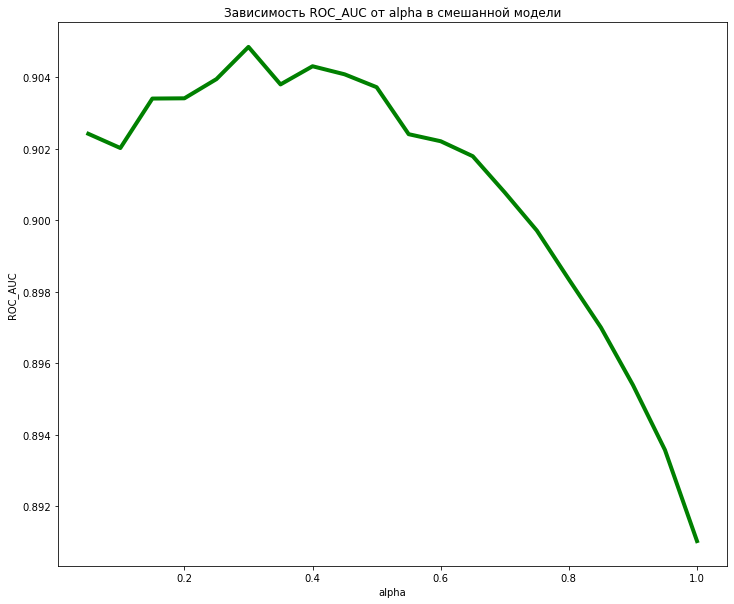

In [287]:
# нарисую график 
fig, ax = plt.subplots(figsize=(12,10))

x_res = [i for i in results['alpha']] 
y_res = results['ROC_AUC']


ax.plot(x_res, y_res, color='green', linewidth=4)
ax.set_xlabel('alpha')
ax.set_ylabel('ROC_AUC')
ax.set_title('Зависимость ROC_AUC от alpha в смешанной модели')

In [ ]:

for a in np.arange(0.05, 1.05, 0.05):
    res_clf = VotingClassifier(estimators=[('KNN', clf_1),('SGD', clf_2)], voting='soft', weights=[a, 1-a])
    scores[a] = cross_val_score(res_clf, data3, y, cv=5, scoring="roc_auc").mean()


In [297]:
%%time
clf_fin = VotingClassifier(estimators=[('KNN', clf_1),('SGD', clf_2)],voting='soft',weights=[0.3, 0.7])
scores_fin = cross_val_score(clf_fin, data3, y,cv=5, scoring="roc_auc")

Wall time: 21.2 s


## Вопрос: дал ли этот подход прирост к качеству по сравнению с моделями ранее?

Лучшее качество модели после смешивания = 0.90485    
Лучшее качество модели ДО смешивания = 0.90367      

Конкретно в нашем случае **смешивание НЕ повлияло на качество предсказания**

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, SGD classifier и т.д.), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [295]:
#your code here
import seaborn as sns

In [293]:
%%time
# Посчитаю ЛУЧШЕЕ качество моделей на cross_val_score
knn_fin = cross_val_score(model_knn_sc3, data3, y, cv=5, scoring='roc_auc')
sgd_fin = cross_val_score(model_sgd_sc3, data3, y, cv=5, scoring='roc_auc')
lsvc_fin = cross_val_score(model_lsvc_sc3, data3, y, cv=5, scoring='roc_auc')
lr_fin = cross_val_score(model_lr_sc3, data3, y, cv=5, scoring='roc_auc')
nb_fin = cross_val_score(model_nb_sc3, data3, y, cv=5, scoring='roc_auc')


C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Wall time: 30.1 s


In [298]:
print('Лучшее качество KNN на 5 фолдах: ', knn_fin)
print('Лучшее качество SGD на 5 фолдах: ', sgd_fin)
print('Лучшее качество LinerSVC на 5 фолдах: ', lsvc_fin)
print('Лучшее качество LR на 5 фолдах: ', lr_fin)
print('Лучшее качество НБА на 5 фолдах: ', nb_fin)
print('Лучшее качество по смешанной модели на 5 фолдах: ', scores_fin)

Лучшее качество KNN на 5 фолдах:  [0.88909842 0.89761269 0.89179622 0.88860388 0.88801721]
Лучшее качество SGD на 5 фолдах:  [0.89755346 0.9079382  0.90333744 0.89973562 0.90035345]
Лучшее качество LinerSVC на 5 фолдах:  [0.88477024 0.89814905 0.89074555 0.88975859 0.89017084]
Лучшее качество LR на 5 фолдах:  [0.89959549 0.90972998 0.90348988 0.90279722 0.90275772]
Лучшее качество НБА на 5 фолдах:  [0.88792114 0.89955545 0.8967024  0.88520263 0.89109995]
Лучшее качество по смешанной модели на 5 фолдах:  [0.8994737  0.91082273 0.90482762 0.90401396 0.90171011]


In [301]:
# Создадим таблицу со значениями фолдов для каждой модели
final = pd.DataFrame({'KNN_fin': knn_fin,
                    'SGD_fin': sgd_fin,
                    'LSVC_fin': lsvc_fin,
                    'LR_fin': lr_fin,
                    'НБА_fin': nb_fin,
                    'Mixed_fin': scores_fin})
final

,KNN_fin,SGD_fin,LSVC_fin,LR_fin,НБА_fin,Mixed_fin
0,0.889098,0.897553,0.884770,0.899595,0.887921,0.899474
1,0.897613,0.907938,0.898149,0.909730,0.899555,0.910823
2,0.891796,0.903337,0.890746,0.903490,0.896702,0.904828
3,0.888604,0.899736,0.889759,0.902797,0.885203,0.904014
4,0.888017,0.900353,0.890171,0.902758,0.891100,0.901710


<AxesSubplot:xlabel='variable', ylabel='value'>

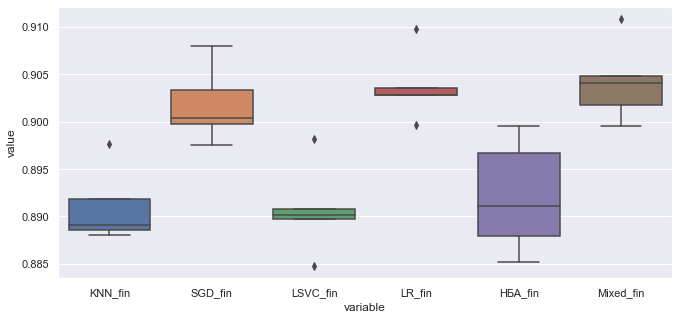

In [306]:
sns.set(rc={'figure.figsize':(11, 5)})
sns.boxplot(x="variable", y="value", data=pd.melt(final))

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

## Выводы

1. После всех проведенных преобразований, качество моделей стало очень похожим      
2. Меньше всего от преобразований выйграл Байесовский классификатор       
3. Заметный скачок в качестве произошел после стандартизации данных: с 0,58-0,6 ДО 0,8-0,83       
4. После добавления dummy-переменных качество возросло не так сильно: ДО 0.9       
5. Гиперпараметры по-разному влияют на качество модели - в KNN влияние было низким, в SGD - чуть больше
6. Наиболее затратными алгоритмами оказались KNN и LinearSVC 
7. По итогам смешивания данных качество осталост неизменным  



# Черновик

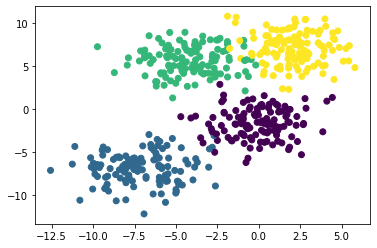

In [126]:
# тестирую make_blobs

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

raw_data = make_blobs(
    n_samples=500, 
    n_features=2, 
    centers=4, 
    cluster_std=1.8)

plt.scatter(raw_data[0][:,0], raw_data[0][:,1], c=raw_data[1])

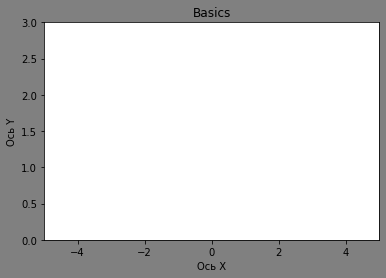

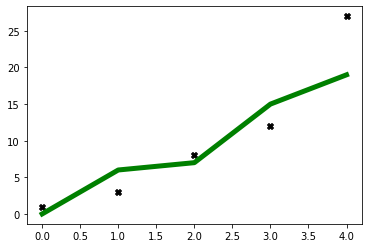

In [191]:
# Повтор matplotlib

import matplotlib.pyplot as plt 

# График 1
fig = plt.figure()
ax = fig.add_subplot()

fig.set_facecolor('grey')
ax.set_facecolor('white')

ax.set_xlim([-5, 5])
ax.set_ylim([0, 3])
ax.set_title('Basics')
ax.set_xlabel('Ось X')
ax.set_ylabel('Ось Y')

# График 2
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1, 2, 3, 4], [0, 6, 7, 15, 19], color = 'green', linewidth = 5)
ax.scatter([0, 1, 2, 3, 4], [1, 3, 8, 12, 27], color = 'black', marker = 'X')

plt.show()

In [57]:
# Тренируюсь на iris
# https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html 
# https://www.machinelearningmastery.ru/a-guide-to-svm-parameter-tuning-8bfe6b8a452c/

from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

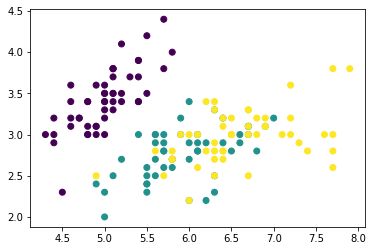

In [58]:
# Нарисую 

sepal_length = iris.data[:,0] 
sepal_width = iris.data[:,1] 
plt.scatter(sepal_length, sepal_width, c=iris.target)

Text(0, 0.5, 'hours-per-week')

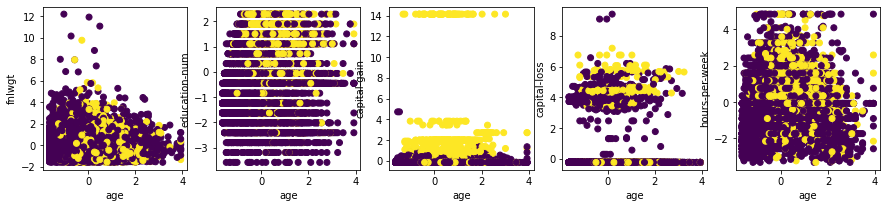

In [67]:
# Импортирую модель для отрисовки гистограмм - matplotlib  
import matplotlib.pyplot as plt

# Задам размер для отрисовки гистограмм
fig, ax = plt.subplots(1,5, figsize=(15,3))

ax[0].scatter(X_int_sc[:,0],X_int_sc[:,1],c=y)
ax[0].set_xlabel('age')
ax[0].set_ylabel('fnlwgt')

ax[1].scatter(X_int_sc[:,0], X_int_sc[:,2],c=y)
ax[1].set_xlabel('age')
ax[1].set_ylabel('education-num')

ax[2].scatter(X_int_sc[:,0], X_int_sc[:,3],c=y)
ax[2].set_xlabel('age')
ax[2].set_ylabel('capital-gain')


ax[3].scatter(X_int_sc[:,0], X_int_sc[:,4],c=y)
ax[3].set_xlabel('age')
ax[3].set_ylabel('capital-loss')

ax[4].scatter(X_int_sc[:,0], X_int_sc[:,5],c=y)
ax[4].set_xlabel('age')
ax[4].set_ylabel('hours-per-week')

#ax[5].scatter(X_int['capital-gain'], y)
#ax[5].set_xlabel('capital-gain')
#ax[5].set_ylabel('target')


# X_int=data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]

Text(0.5, 1.0, 'capital-gain')

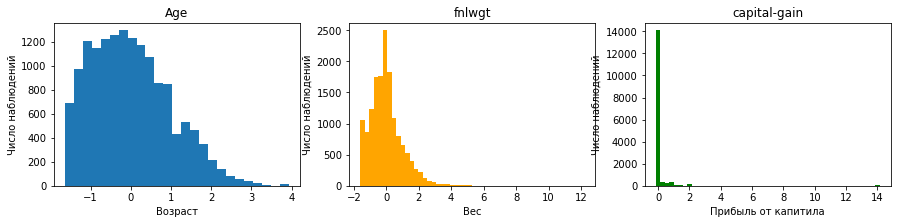

In [70]:
# Задам размер для отрисовки гистограмм
fig, ax = plt.subplots(1,3, figsize=(15,3))

# Рисую гистограмму по возрасту
ax[0].hist(X_int_sc[:,0], bins=25)
ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Число наблюдений')
ax[0].set_title('Аge')


# Рисую гистограмму по весу 'fnlwgt'
ax[1].hist(X_int_sc[:,1], bins=50, color='orange')
ax[1].set_xlabel('Вес')
ax[1].set_ylabel('Число наблюдений')
ax[1].set_title('fnlwgt')


# Рисую гистограмму по размеру прибыли от капитила 'capital-gain'
ax[2].hist(X_int_sc[:,3], bins=50, color='green')
ax[2].set_xlabel('Прибыль от капитила')
ax[2].set_ylabel('Число наблюдений')
ax[2].set_title('capital-gain')

In [68]:
from sklearn.svm import SVC 
clf = SVC(kernel='linear') 
clf.fit(np.c_[sepal_length, sepal_width], iris.target) create_grid_plot(clf, sepal_length, sepal_width)

SyntaxError: invalid syntax (<ipython-input-68-683773e9eaa6>, line 3)